# Trabajo Fin de Máster (TFM)
## OPCIÓN 1: Predicción de la calidad del crédito
Miguel Corral Martínez

### 1. Carga del conjunto de datos

In [1]:
import pandas as pd

# cargamos el dataset 
df = pd.read_csv('creditg.csv')

# mostramos las primeras 5 filas
df.head()

,ID,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,vty,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,dkl,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,bwf,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,qln,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,uzh,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


### 2. Sesión de análisis exploratorio

In [2]:
# resumen estadístico de las variables numéricas
df.describe()


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.746000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,12.367961,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,149.000000,4.000000,2.000000


In [3]:
# elimino la columna ID porque genera datos y gráficos sin valor ya que es un identificador único, aunque no sé si aquí es el lugar correcto para hacerlo
df = df.drop(columns=['ID'])

# resumen de las variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns].describe()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,class
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,990,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2,2
top,no checking,existing paid,radio/tv,<100,1<=X<4,male single,none,car,none,own,skilled,none,yes,good
freq,394,530,280,603,339,548,907,332,814,713,630,587,963,700


In [4]:
# información general del dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

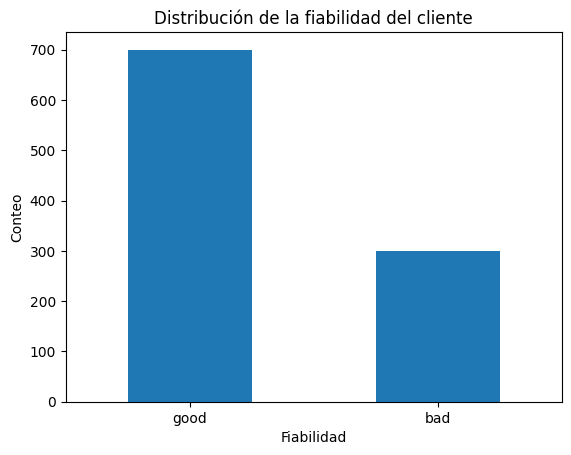

In [5]:
import matplotlib.pyplot as plt

# distribución de la variable objetivo 'class' (good/bad)
df['class'].value_counts().plot(kind='bar')
plt.title('Distribución de la fiabilidad del cliente')
plt.xlabel('Fiabilidad')
plt.ylabel('Conteo')
plt.xticks(rotation=0)
plt.show()

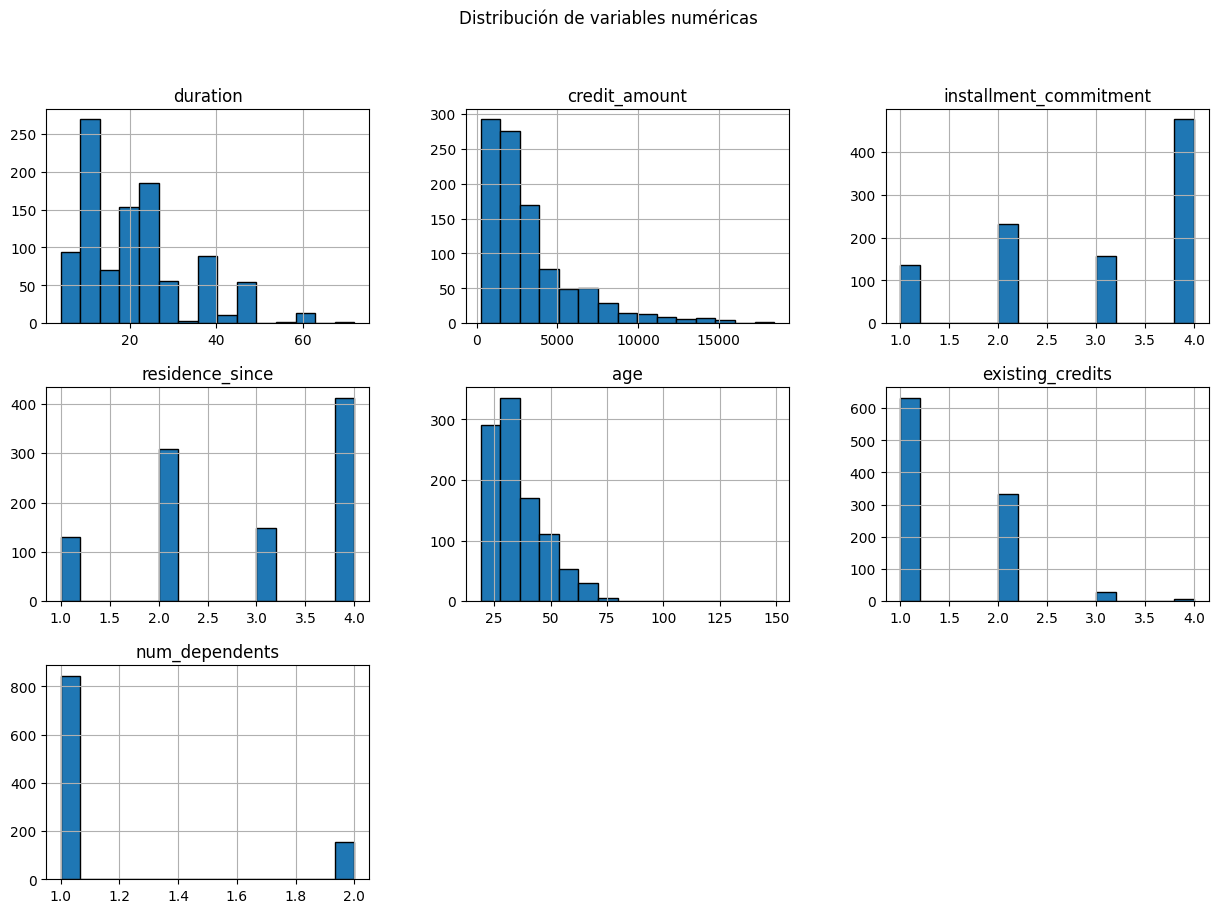

In [6]:
# histograma para las variables numéricas 
num_columns = df.select_dtypes(include=['number']).columns
df[num_columns].hist(figsize=(15, 10), bins=15, edgecolor='black')
plt.suptitle('Distribución de variables numéricas')
plt.show()

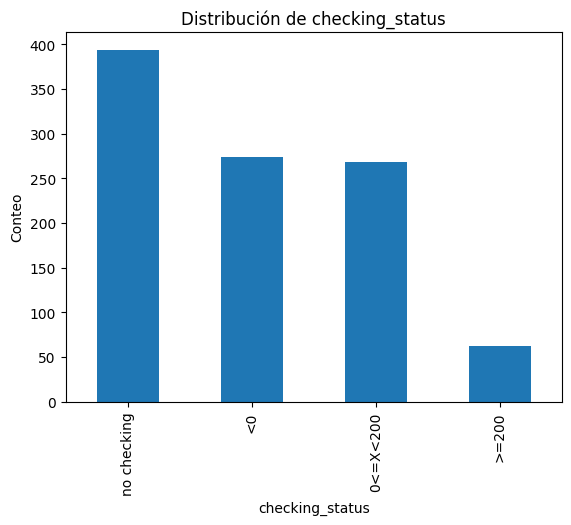

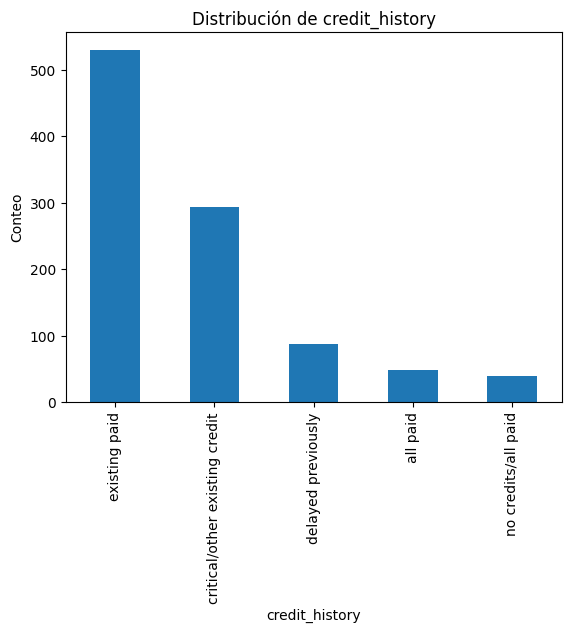

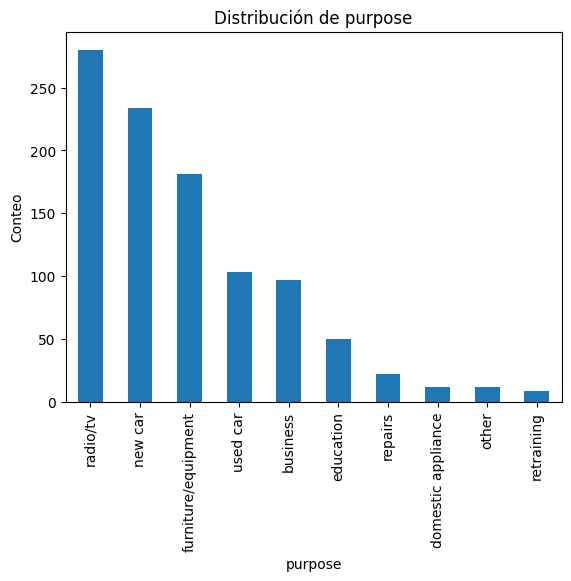

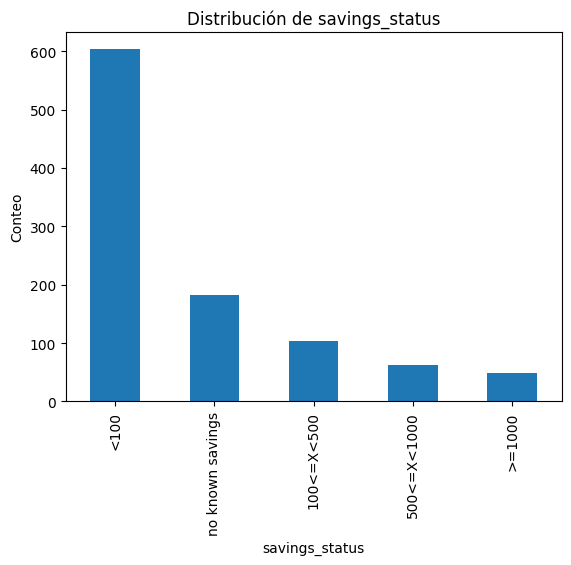

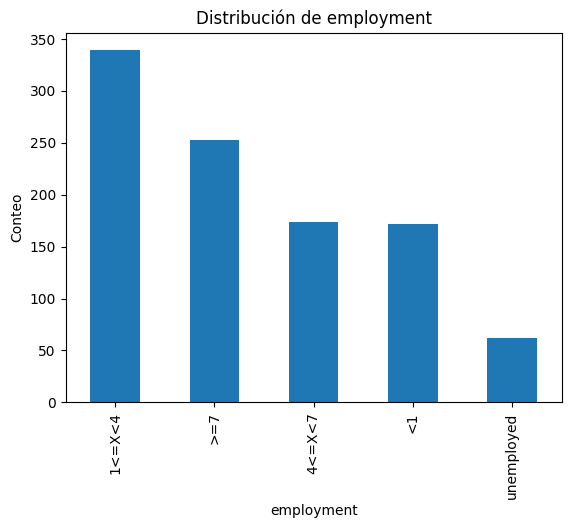

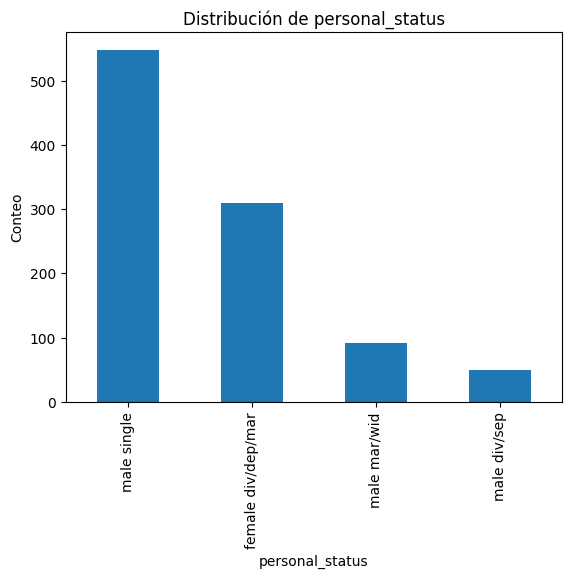

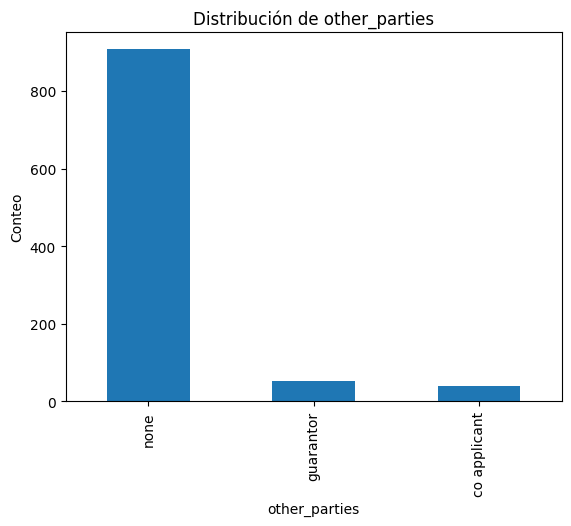

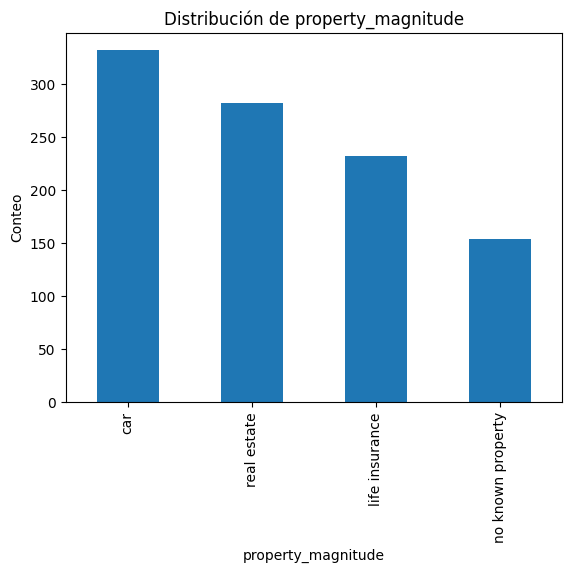

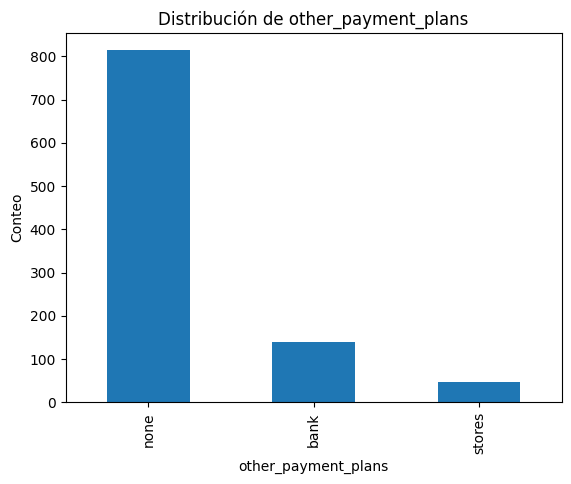

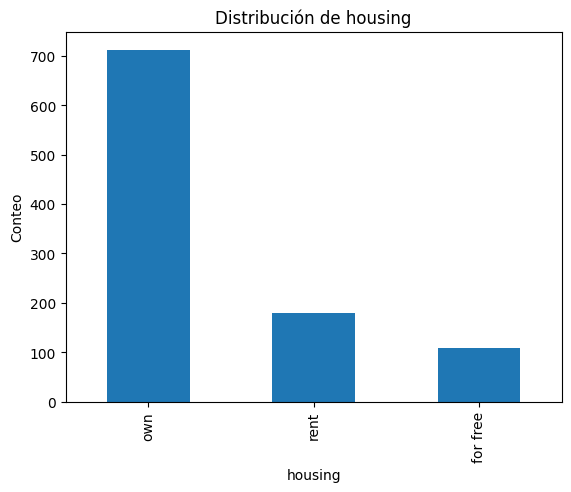

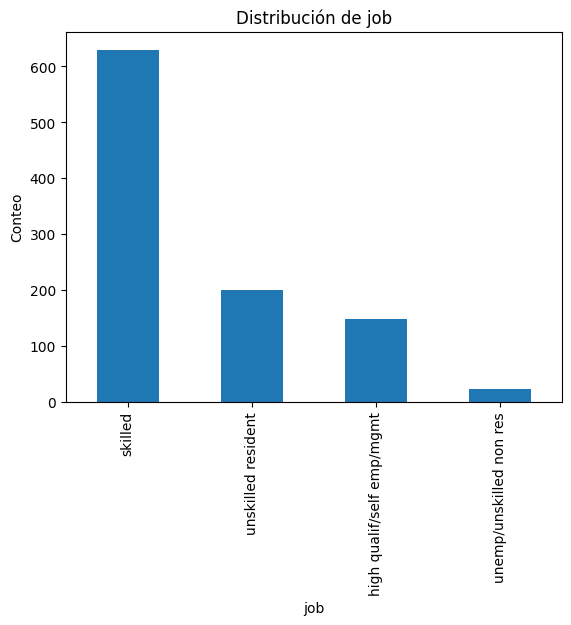

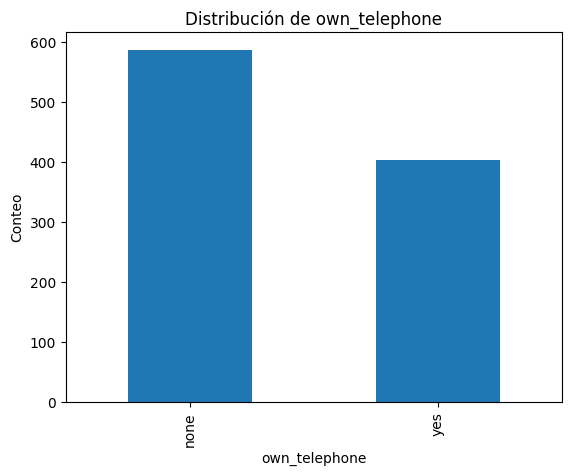

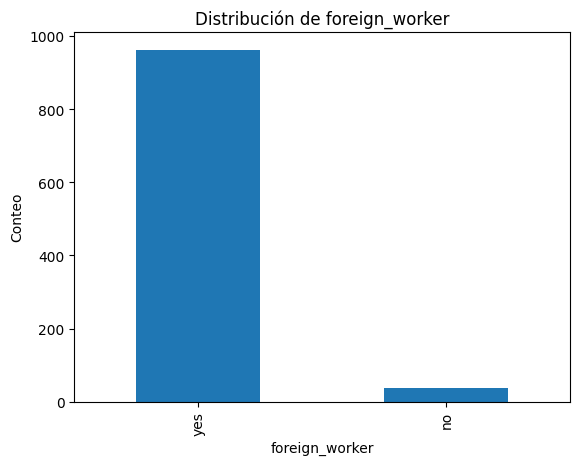

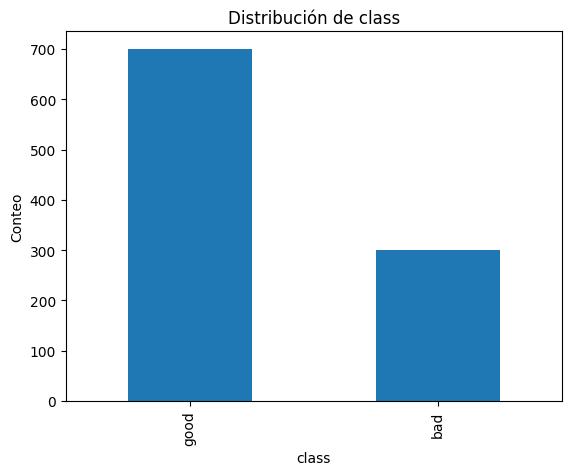

In [7]:
import matplotlib.pyplot as plt

# crear gráficos de barras para cada variable categórica
for column in categorical_columns:
    plt.figure()
    df[column].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Conteo')
    plt.show()


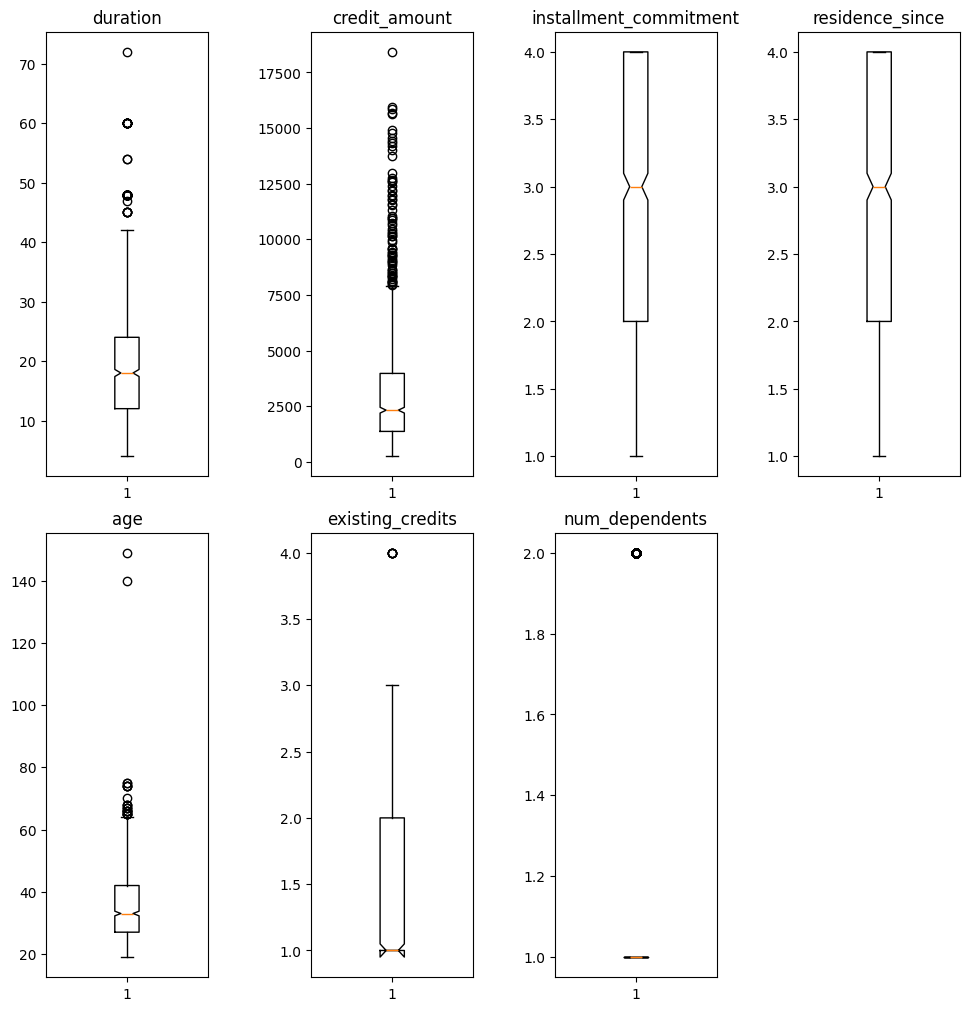

In [15]:
# crear gráficos de cajas y bigotes para las variables numéricas para detectar outliers

num_columns = df.select_dtypes(include=['number']).columns

fig = plt.figure(figsize=(10, 10))
fig.set_constrained_layout(True)           # Modo restringido/manual
fig.set_constrained_layout_pads(w_pad=.25) # Margen lateral

for i, var in enumerate(num_columns):
    ax = fig.add_subplot(2, len(num_columns) // 2 + len(num_columns) % 2, i + 1) # Colocar subplots en 2 filas
    ax.set(title=var)
    ax.boxplot(df[var], notch=True)

plt.show()

### 3. Preprocesamiento de los datos

In [19]:
# limpiar edades no válidas (por ejemplo hay una edad de 149 años)
min_age = 18
max_age = 100

df_clean = df[(df['age'] >= min_age) & (df['age'] <= max_age)]

# mostrar estadísticas de la variable 'age' después de limpiar
print(df_clean['age'].describe())


count    998.000000
mean      35.528056
std       11.378009
min       19.000000
25%       27.000000
50%       33.000000
75%       42.000000
max       75.000000
Name: age, dtype: float64


In [9]:
# buscar duplicados y eliminarlos
duplicates = df_clean.duplicated()
print(f"Duplicados encontrados: {duplicates.sum()}")
if duplicates.sum() > 0:
    df_clean = df_clean.drop_duplicates()

Duplicados encontrados: 0


In [ ]:
# guardar el dataframe limpio
df_clean.to_csv('creditg_clean.csv', index=False)